In [1]:
%load_ext autoreload
%autoreload 2


In [ ]:
#colab stuff
!pip install catboost==1.0.3
!pip install shap

!unzip utils.zip

!mkdir data
!wget https://voudy-data.s3.eu-north-1.amazonaws.com/wsdm_data.tar.gz -P data
!tar xf data/wsdm_data.tar.gz -C data

In [34]:
import os
import shap
import numpy as np
import pandas as pd

from utils.data import load_data

from sklearn.model_selection import GroupKFold, train_test_split
from catboost import CatBoostRanker, Pool, MetricVisualizer

In [4]:
SEED = 12
DATA_PATH = "data"

# Data loading & parsing

In [5]:
train = load_data(DATA_PATH, load_test=False) 

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7375811 entries, 0 to 7377417
Data columns (total 27 columns):
 #   Column                   Dtype   
---  ------                   -----   
 0   msno                     category
 1   song_id                  category
 2   source_system_tab        category
 3   source_screen_name       category
 4   source_type              category
 5   target                   int64   
 6   city                     category
 7   bd                       category
 8   gender                   category
 9   registered_via           int64   
 10  registration_init_year   category
 11  registration_init_month  category
 12  registration_init_day    category
 13  expiration_year          category
 14  expiration_month         category
 15  expiration_day           category
 16  song_length              float64 
 17  genre_ids                category
 18  artist_name              category
 19  composer                 category
 20  lyricist                

# 1. Ranking with GBDT 

In [24]:
train_group = train.groupby("msno").head(1023).reset_index(drop=True)
train_group.sort_values("msno", kind="stable", inplace=True)

In [25]:
X = train_group.drop(["target", "msno", "song_id"], axis=1)  # поправил дроп, сначала забыл дропнуть айди и msno, кек
y = train_group.target.to_numpy()
q = train_group.msno.cat.codes.to_numpy()

categorical_features = X.select_dtypes(["category"]).columns.to_numpy()

In [26]:
catboost_config = {
    "loss_function": "YetiRank", 
    "iterations": 150, 
    "custom_metric": ["NDCG", "QueryAUC:type=Ranking"], 
    "random_seed": SEED, 
    "metric_period": 25,
    "task_type": "GPU",
    "train_dir": "YetiRank/" 
}

In [27]:
scores = []

for train_idx, val_idx in GroupKFold(n_splits=5).split(X, y, q):
    X_train, y_train = X.iloc[train_idx], y[train_idx]
    X_val, y_val = X.iloc[val_idx], y[val_idx]
    q_train, q_val = q[train_idx], q[val_idx]

    pool_train = Pool(
        data=X_train, label=y_train, group_id=q_train, 
        cat_features=categorical_features, has_header=True)
    
    pool_val = Pool(
        data=X_val, label=y_val, group_id=q_val, 
        cat_features=categorical_features, has_header=True)
    
    model = CatBoostRanker(**catboost_config)
    model.fit(pool_train, eval_set=pool_val)
    
    scores.append(model.get_evals_result())

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Groupwise loss function. OneHotMaxSize set to 10


Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric QueryAUC:type=Ranking is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6142339	best: 0.6142339 (0)	total: 2.14s	remaining: 5m 19s
25:	test: 0.7240738	best: 0.7240738 (25)	total: 33.2s	remaining: 2m 38s
50:	test: 0.7321384	best: 0.7321384 (50)	total: 1m 4s	remaining: 2m 4s
75:	test: 0.7439980	best: 0.7439980 (75)	total: 1m 35s	remaining: 1m 32s
100:	test: 0.7503373	best: 0.7503373 (100)	total: 2m 6s	remaining: 1m 1s
125:	test: 0.7654211	best: 0.7654211 (125)	total: 2m 37s	remaining: 30.1s
149:	test: 0.7672638	best: 0.7672638 (149)	total: 3m 8s	remaining: 0us
bestTest = 0.7672638039
bestIteration = 149
Groupwise loss function. OneHotMaxSize set to 10


Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric QueryAUC:type=Ranking is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6154538	best: 0.6154538 (0)	total: 2.04s	remaining: 5m 4s
25:	test: 0.6507146	best: 0.6507146 (25)	total: 33s	remaining: 2m 37s
50:	test: 0.7413196	best: 0.7413196 (50)	total: 1m 4s	remaining: 2m 4s
75:	test: 0.7492276	best: 0.7492276 (75)	total: 1m 35s	remaining: 1m 32s
100:	test: 0.7506512	best: 0.7506512 (100)	total: 2m 6s	remaining: 1m 1s
125:	test: 0.7585550	best: 0.7585550 (125)	total: 2m 37s	remaining: 30.1s
149:	test: 0.7649955	best: 0.7649955 (149)	total: 3m 8s	remaining: 0us
bestTest = 0.7649955057
bestIteration = 149
Groupwise loss function. OneHotMaxSize set to 10


Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric QueryAUC:type=Ranking is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.5137879	best: 0.5137879 (0)	total: 2.04s	remaining: 5m 4s
25:	test: 0.7361169	best: 0.7361169 (25)	total: 33.3s	remaining: 2m 38s
50:	test: 0.7385869	best: 0.7385869 (50)	total: 1m 4s	remaining: 2m 5s
75:	test: 0.7421794	best: 0.7421794 (75)	total: 1m 35s	remaining: 1m 33s
100:	test: 0.7472163	best: 0.7472163 (100)	total: 2m 7s	remaining: 1m 1s
125:	test: 0.7531311	best: 0.7531311 (125)	total: 2m 38s	remaining: 30.2s
149:	test: 0.7667084	best: 0.7667084 (149)	total: 3m 8s	remaining: 0us
bestTest = 0.7667084037
bestIteration = 149
Groupwise loss function. OneHotMaxSize set to 10


Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric QueryAUC:type=Ranking is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.5511513	best: 0.5511513 (0)	total: 2.09s	remaining: 5m 11s
25:	test: 0.6645039	best: 0.6645039 (25)	total: 33.2s	remaining: 2m 38s
50:	test: 0.7312049	best: 0.7312049 (50)	total: 1m 4s	remaining: 2m 5s
75:	test: 0.7468057	best: 0.7468057 (75)	total: 1m 35s	remaining: 1m 33s
100:	test: 0.7508050	best: 0.7508050 (100)	total: 2m 6s	remaining: 1m 1s
125:	test: 0.7637237	best: 0.7637237 (125)	total: 2m 38s	remaining: 30.1s
149:	test: 0.7796088	best: 0.7796088 (149)	total: 3m 8s	remaining: 0us
bestTest = 0.7796087875
bestIteration = 149
Groupwise loss function. OneHotMaxSize set to 10


Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric QueryAUC:type=Ranking is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.5497762	best: 0.5497762 (0)	total: 2.08s	remaining: 5m 10s
25:	test: 0.7227052	best: 0.7227052 (25)	total: 33.3s	remaining: 2m 38s
50:	test: 0.7272834	best: 0.7272834 (50)	total: 1m 4s	remaining: 2m 5s
75:	test: 0.7286136	best: 0.7286136 (75)	total: 1m 35s	remaining: 1m 33s
100:	test: 0.7395034	best: 0.7395034 (100)	total: 2m 7s	remaining: 1m 1s
125:	test: 0.7498921	best: 0.7498921 (125)	total: 2m 38s	remaining: 30.2s
149:	test: 0.7700115	best: 0.7700115 (149)	total: 3m 9s	remaining: 0us
bestTest = 0.7700115234
bestIteration = 149


## Validation scores

In [28]:
import matplotlib.pyplot as plt

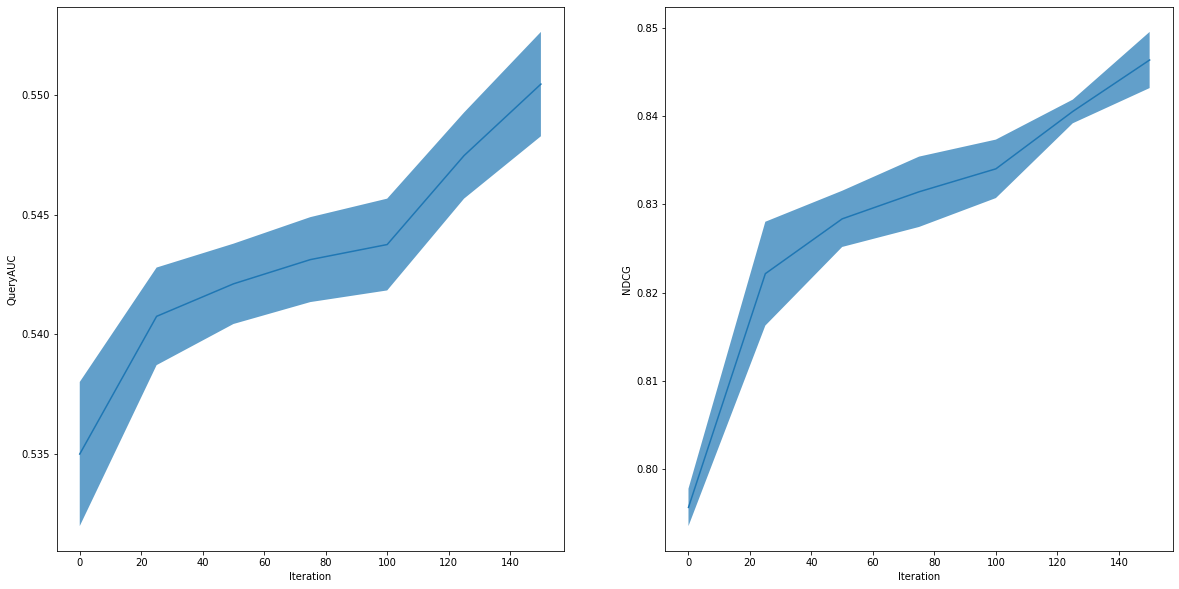

In [29]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(20, 10))

query_auc = np.vstack([x["validation"]["QueryAUC:type=Ranking"] for x in scores])
auc_mean, auc_std = query_auc.mean(axis=0), query_auc.std(axis=0)

ndcg = np.vstack([x["validation"]["NDCG:type=Base"] for x in scores])
ndcg_mean, ndcg_std = ndcg.mean(axis=0), ndcg.std(axis=0)

x = np.arange(catboost_config["iterations"] // catboost_config["metric_period"] + 1) * catboost_config["metric_period"]

ax1.plot(x, auc_mean)
ax1.fill_between(x, auc_mean - auc_std, auc_mean + auc_std, alpha=0.7)
ax1.set_ylabel("QueryAUC")
ax1.set_xlabel("Iteration")

ax2.plot(x, ndcg_mean)
ax2.fill_between(x, ndcg_mean - ndcg_std, ndcg_mean + ndcg_std, alpha=0.7)
ax2.set_ylabel("NDCG")
ax2.set_xlabel("Iteration");

Есть ощущение, что я сильно недоучил, но catboost даже на gpu обучается недостаточно быстро, чтобы делать перебор параметров или большее количество итераций, иначе colab упадет раньше (или забанит, а он еще для следующей домашки нужен) :\

In [32]:
idxs_train, idxs_test = map(sorted, train_test_split(np.random.permutation(len(train_group)), test_size=1000))

X_train = train_group.iloc[idxs_train].drop(["target", "song_id", "msno"], axis=1)
y = train_group.iloc[idxs_train].target.to_numpy()
q = train_group.iloc[idxs_train].msno.cat.codes.to_numpy()

categorical_features = X_train.select_dtypes(["category"]).columns.to_numpy()

pool_train = Pool(data=X_train, label=y, group_id=q, cat_features=categorical_features, has_header=True)

model = CatBoostRanker(**catboost_config)
model.fit(pool_train)

Groupwise loss function. OneHotMaxSize set to 10


Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric QueryAUC:type=Ranking is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	total: 1.69s	remaining: 4m 11s
25:	total: 39.7s	remaining: 3m 9s
50:	total: 1m 17s	remaining: 2m 30s
75:	total: 1m 55s	remaining: 1m 52s
100:	total: 2m 33s	remaining: 1m 14s
125:	total: 3m 12s	remaining: 36.6s
149:	total: 3m 48s	remaining: 0us


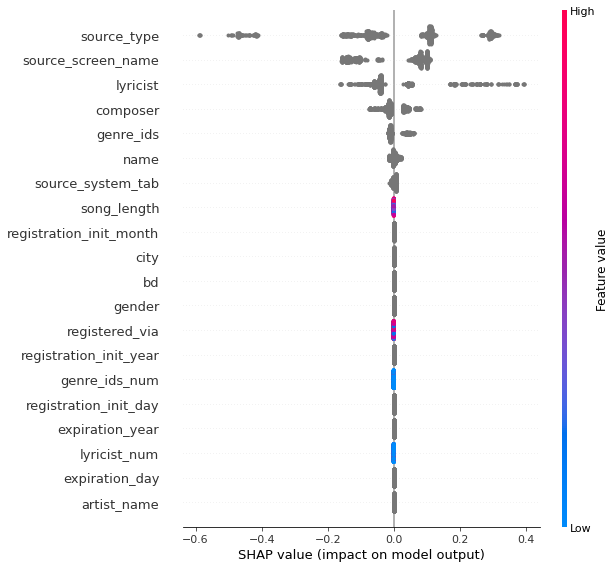

In [35]:
X_test = train_group.iloc[idxs_test].drop(columns=["target", "song_id", "msno"], axis=1)

se = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent")
shap_vals = se.shap_values(X_test)
shap.summary_plot(shap_vals, X_test)

In [36]:
shap.initjs()
shap.force_plot(se.expected_value, shap_vals, X_test)

# 2. Embeddings

TODO (or not TODO) 